# Data Visualization Utilities

Because I should probably start standardizing my data exploration.

In [2]:
import numpy as np
import sys
import os
import pandas as pd
from nltk import word_tokenize
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import re

sys.path.append('..')
from imp import reload
from data import reddit_preprocessor, DataHelper
from data.reddit_preprocessor import *
import json
from pprint import pprint
from jupyterthemes import jtplot

jtplot.style('onedork', ticks=True, fscale=1.5)
jtplot.figsize(x=11., y=8.)
DATA_ROOT = '/home/brandon/Datasets/test_data'
FROM = os.path.join(DATA_ROOT, 'train_from.txt')
TO = os.path.join(DATA_ROOT, 'train_to.txt')

In [ ]:
COL_NAMES = ['inp_sentence', 'resp_sentence']

def make_dataframe(data_dir):
    """
    data_dir: contains train_from.txt, train_to.txt
    """
    from_lines = []
    to_lines = []
    with open(os.path.join(data_dir, 'train_from.txt'), 'r') as from_file:
        with open(os.path.join(data_dir, 'train_to.txt'), 'r') as to_file:
            from_line = from_file.readline()
            to_line = to_file.readline()
            while from_line and to_line:
                from_lines.append(from_line.strip())
                to_lines.append(to_line.strip())
                from_line = from_file.readline()
                to_line = to_file.readline()
            df = pd.DataFrame(np.stack((from_lines, to_lines), 1),
                              columns=COL_NAMES)        
        return df
    
def word_tokenize(df):
    word_freq = {}
    
    # I know. I KNOW.
    sentences = np.squeeze(list(((map(
        DataHelper.word_tokenizer, 
        list(np.expand_dims(df[COL_NAMES[0]].values, 1)))))))
    
    word_freq['from'] = Counter(chain.from_iterable(sentences))
    # Stop judging me.
    sentences = np.squeeze(list(((map(
        DataHelper.word_tokenizer, 
        list(np.expand_dims(df[COL_NAMES[1]].values, 1)))))))
    word_freq['to'] = Counter(chain.from_iterable(sentences))
    
    return word_freq

def plot_freq_dist(word_freq, n):
    words_dict = {}
    for dist in word_freq:
        most_comm = word_freq[dist].most_common(n)
        words, counts = zip(*most_comm)
        words_dict[dist] = words
        counts_series = pd.Series.from_array(counts)

        plt.figure(figsize=(8, 5))
        ax = counts_series.plot(kind='bar')

        ax.set_title('Frequency Distribution: ' + dist)
        ax.set_ylabel('Counts')
        ax.set_xlabel('Words')
        ax.set_xticklabels(words_dict[dist])

    from_words = set(words_dict['from'])
    to_words = set(words_dict['to'])
    common_words = from_words.intersection(to_words)
    common_word_freqs = [
        [word_freq['from'][w] for w in common_words],
        [word_freq['to'][w] for w in common_words]]
    
    ind = np.arange(len(common_words))
    plt.figure(figsize=(8, 5))
    p1 = plt.bar(ind, common_word_freqs[0], width=0.5, color='b')
    p2 = plt.bar(ind, common_word_freqs[1], width=0.5, color='r')
    plt.xticks(ind, common_words)
    plt.legend((p1[0], p2[0]), ('From', 'To'))
    return common_words

In [ ]:
pd.set_option('display.max_colwidth', 10000)
df = make_dataframe(DATA_ROOT)

In [ ]:
pd.set_option('display.max_colwidth', 10000)
df.head(len(df.index))

In [ ]:
word_freq = word_tokenize(df)

In [ ]:
common_words = plot_freq_dist(word_freq, 5)

In [ ]:
common_words

# From TensorBoard to JSON to Matplotlib

In [3]:
import os
import numpy as np
import pandas as pd
import yaml
import re
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
from scipy.interpolate import spline
jtplot.style('onedork', ticks=True, fscale=1.5)
jtplot.figsize(x=11., y=8.)
pd.set_option('display.max_colwidth', 1000)

# --------------------------------------------------------
# Globals
# --------------------------------------------------------
SEQ = os.getenv('SEQ')
STATIC = os.getenv('STATIC')

BASE_DIR = os.path.join(os.getcwd(), 'individual_tb_plots')
ACC_DIR = os.path.join(BASE_DIR, 'accuracy')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
COL_NAMES =  ['wall_time', 'iteration']

Format the dictionary configuration dictionaries

In [4]:
from copy import deepcopy

omfg = {}
configs = {}
run_keys = set()
for fname in os.listdir(ACC_DIR):
    name = re.search(r'(?:-)(\w+)(?:-)', fname).group(0)[1:-1]
    run_keys.add(name)
run_keys = list(run_keys)


for k in run_keys:
    fname = os.path.join(SEQ, 'out/cornell', k, 'config.yml')
    with open(fname, 'r') as config_file:
        configs[k] = yaml.load(config_file)

def filtered_configs(configs):
    _configs = [(k, deepcopy(configs[k])) for k in configs]
    # Remove dataset name (assuming they're all cornell)
    _configs = list(filter(lambda c: c[1].pop('dataset'), _configs))
    # Remove model name (all are DynamicBot)
    _configs = list(filter(lambda c: c[1].pop('model'), _configs))
    # misc.
    _configs = list(filter(lambda c: c[1]['model_params'].pop('ckpt_dir'), _configs))

    for k in ['model_params', 'dataset_params']:
        kk_list = list(_configs[0][1][k])
        for kk in kk_list:
            vals = set()
            for conf in _configs:
                conf = conf[1]
                vals.add(conf[k].get(kk))
            if len(vals) == 1 and 'attention' not in kk:
                # Remove items that are all the same.
                _wtf = list(filter(lambda c: c[1][k].pop(kk), _configs))
                if _wtf: _configs = _wtf
    return {k: v for k, v in _configs}
            
def renamed(name):
    _omfg = name
    if 'idi' in name:
        name = name.replace('basic', '')
        name = name.replace('bidi', 'Bidi')
    name = name.replace('basic', 'Basic')
    if 'LSTM' not in name:
        name += 'GRU'
    omfg[_omfg] = name
    return name

f_configs = filtered_configs(configs)
f_configs = {renamed(n): v for n, v in f_configs.items()}
pprint(f_configs)
pprint(omfg)


{'BasicDeepGRU': {'dataset_params': {'config_path': 'configs/cornell.yml'},
                  'model_params': {'attention_size': None,
                                   'base_cell': 'GRUCell',
                                   'batch_size': 256,
                                   'encoder.class': 'BasicEncoder',
                                   'num_layers': 3}},
 'BasicGRU': {'dataset_params': {'config_path': 'configs/cornellBasic.yml'},
              'model_params': {'attention_size': None,
                               'base_cell': 'GRUCell',
                               'batch_size': 256,
                               'encoder.class': 'BasicEncoder',
                               'num_layers': 1}},
 'BasicLSTM': {'dataset_params': {'config_path': 'configs/example_cornell.yml'},
               'model_params': {'base_cell': 'LSTMCell',
                                'batch_size': 256,
                                'encoder.class': 'BasicEncoder',
                         

In [6]:
df_acc = {}
df_train = {}
df_valid = {}

for k in run_keys:
    fname = 'run-'+k+'-tag-evaluation_accuracy.json'
    df_acc[omfg[k]] = pd.read_json(os.path.join(ACC_DIR, fname))
    
    fname = 'run-'+k+'-tag-evaluation_loss_train.json'
    df_train[omfg[k]] = pd.read_json(os.path.join(TRAIN_DIR, fname))
    
    fname = 'run-'+k+'-tag-evaluation_loss_valid.json'
    df_valid[omfg[k]] = pd.read_json(os.path.join(VALID_DIR, fname))

    df_acc[omfg[k]].columns = COL_NAMES + ['accuracy']
    df_train[omfg[k]].columns = COL_NAMES + ['training loss']
    df_valid[omfg[k]].columns = COL_NAMES + ['validation loss']

In [95]:
run_keys = list(f_configs.keys())
def plot_df(df, y_name, run_key, n_points=25, use_spline=True, plot_perp=False):
    """Assuming df is from tensorboard json . . . """
    if plot_perp:
        df = df.loc[2:]
        df[y_name] = np.exp(df[y_name])
    
    if use_spline:
        iters = df.iteration
        iters_new = np.linspace(iters.min(), iters.max(), n_points)
        smooth_y = spline(iters, df[y_name], iters_new)
        plt.plot(iters_new, smooth_y, label=run_key)
    else:
        plt.plot(df['iteration'], df[y_name], label=run_key)
        
    plt.title(y_name.title())
    plt.ylabel(y_name)
    if y_name == 'accuracy':
        plt.ylim([0., 1.])
        plt.yticks(list(np.arange(
            0., float(plt.yticks()[0][-1])+0.1, step=0.1)))
        leg_kwargs = dict(fontsize='x-small',
                          loc='upper left')
    else:
        plt.yticks(list(np.arange(
            0., float(plt.yticks()[0][-1])+1., step=1.)))
        leg_kwargs = dict(fontsize='small',
                          loc='upper right')
    plt.xlim([0., 1.0e4])
    plt.xlabel('Iteration')
    plt.legend(**leg_kwargs)

def plot_runs(df_dict, y_name, n_points=25, 
              use_spline=True, plot_perp=False,
              figsize=(10,7)):
    """Calls plot_df for each key in the df_dict."""
    fig = plt.figure(figsize=figsize)
    for k in run_keys:
        plot_df(deepcopy(df_dict[k]), y_name, k, 
               n_points=n_points,
               use_spline=use_spline,
               plot_perp=plot_perp)
    return fig

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


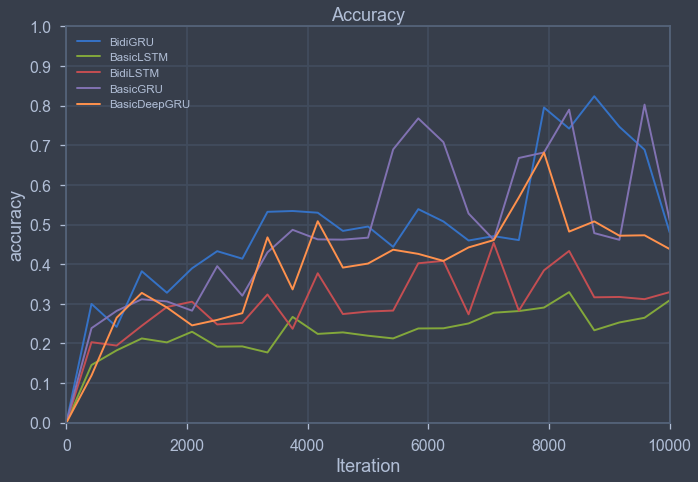

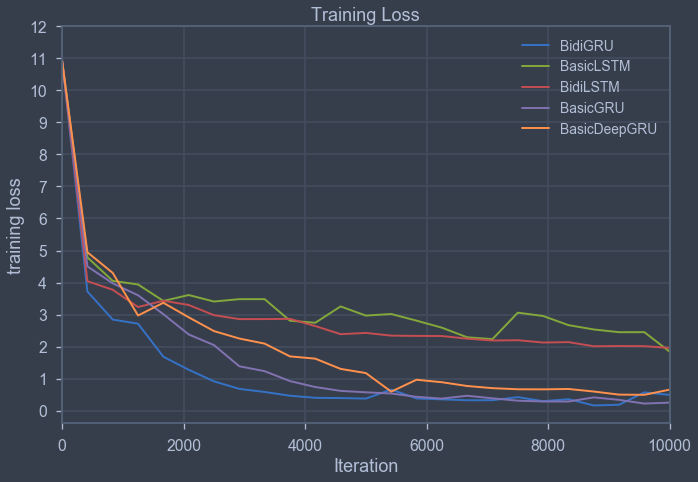

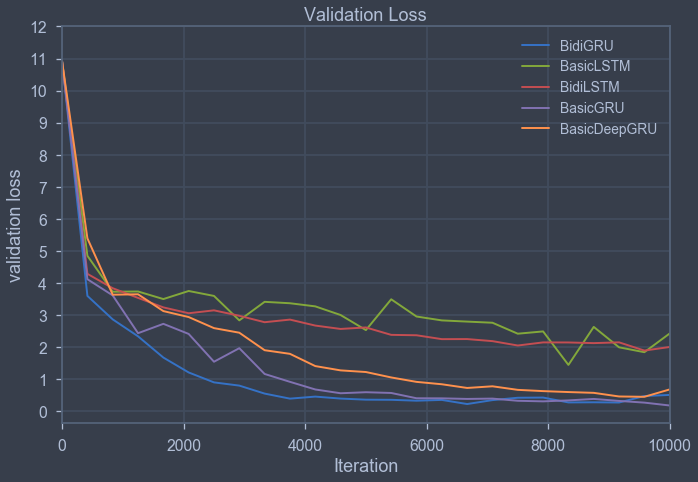

In [96]:
jtplot.style('onedork', ticks=True, context='talk', fscale=1.5)
acc_fig = plot_runs(df_acc, 'accuracy')
train_fig = plot_runs(df_train, 'training loss')
valid_fig = plot_runs(df_valid, 'validation loss')
plt.show()

In [97]:
html_dir = os.path.join(STATIC, 'assets/plots')
for fname, fig in {'accuracy': acc_fig, 'training': train_fig, 'validation': valid_fig}.items():
    with open(os.path.join(html_dir, fname+'.json'), 'w') as f:
        mpld3.save_json(fig, f)

with open(os.path.join(html_dir, 'configs.json'), 'w') as f:
    json.dump(f_configs, f)

In [76]:
os.listdir(html_dir)

['training.json', 'configs.json', 'accuracy.json', 'validation.json']

In [77]:
html_dir

'/home/brandon/Documents/DeepChatModels/webpage/deepchat/static/assets/plots'